# Recurrent Neural Network

## Data

In [1]:
import string
from io import open
import glob
import os
import unicodedata

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def read_files():
    def find_files(path): 
        return glob.glob(path)
    
    category_lines = {}
    all_categories = []
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

category_lines, all_categories = read_files()
n_categories = len(all_categories)

## Model

In [2]:
import torch
import torch.nn as nn

def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.to(get_device())

criterion = nn.NLLLoss()

## Training

### Training setup

In [3]:
import numpy as np
from numpy.random import normal
import torch.optim as optim
import random
import time
import math

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def letter_to_index(letter, all_letters):
    return all_letters.find(letter)

def line_to_tensor(line, all_letters):
    n_letters = len(all_letters)
    n_chars = len(line)
    
    tensor = torch.zeros(n_chars, 1, n_letters)
    
    for char_index, letter in enumerate(line):
        letter_index = letter_to_index(letter, all_letters) 
        tensor[char_index][0][letter_index] = 1
        
    return tensor

def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def random_choice(arr):
    n = len(arr)
    r = random.randint(0, n - 1)
    return arr[r]

def random_training_example(all_categories, category_lines, all_letters):
    category = random_choice(all_categories)
    category_index = all_categories.index(category)
    category_tensor = torch.tensor([category_index], dtype=torch.long)
    
    line = random_choice(category_lines[category])
    line_tensor = line_to_tensor(line, all_letters)
    
    return category, line, category_tensor, line_tensor

def train(rnn, criterion, category_tensor, line_tensor, learning_rate=0.005):
    hidden = rnn.initHidden()

    line_tensor = line_tensor.to(get_device())
    category_tensor = category_tensor.to(get_device())
    hidden = hidden.to(get_device())
    
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m):2}m {int(s):2}s'

### Training loop

In [4]:
n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

start = time.time()

for it in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = \
        random_training_example(all_categories, category_lines, all_letters)
    
    output, loss = train(rnn, criterion, category_tensor, line_tensor)
    current_loss += loss

    if it % print_every == 0:
        guess, guess_i = category_from_output(output, all_categories)
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{it:6}, {it/n_iters*100:3.0f}%, ({time_since(start)}), {loss:.4f}, {line}, {guess}, {correct}')

    if it % plot_every == 0:
        all_losses.append((it, current_loss / plot_every))
        current_loss = 0

  5000,   5%, ( 0m  7s), 2.7873, Lim , Chinese, ✗ (Korean)
 10000,  10%, ( 0m 15s), 2.4086, Ruaidh, Arabic, ✗ (Irish)
 15000,  15%, ( 0m 23s), 0.5093, Shamoun, Arabic, ✓
 20000,  20%, ( 0m 31s), 1.2996, Noguerra, Spanish, ✓
 25000,  25%, ( 0m 39s), 0.9563, Piontek, Polish, ✓
 30000,  30%, ( 0m 47s), 1.8069, Abreu, French, ✗ (Portuguese)
 35000,  35%, ( 0m 55s), 3.4189, Tomas, Greek, ✗ (Spanish)
 40000,  40%, ( 1m  3s), 0.8602, Dao, Chinese, ✗ (Vietnamese)
 45000,  45%, ( 1m 11s), 0.1132, Wronski, Polish, ✓
 50000,  50%, ( 1m 19s), 1.5474, Poingdestre, French, ✓
 55000,  55%, ( 1m 27s), 1.6692, Morton, English, ✓
 60000,  60%, ( 1m 35s), 0.5828, Mochan, Irish, ✓
 65000,  65%, ( 1m 42s), 0.0576, Aconi, Italian, ✓
 70000,  70%, ( 1m 50s), 2.9694, Rigg, Chinese, ✗ (English)
 75000,  75%, ( 1m 58s), 1.8027, Zogby, Czech, ✗ (Arabic)
 80000,  80%, ( 2m  6s), 1.0814, Mckay, Scottish, ✓
 85000,  85%, ( 2m 14s), 0.9149, Woo, Korean, ✓
 90000,  90%, ( 2m 22s), 0.7674, Faucheux, French, ✓
 95000, 

## Evaluation

### Loss

Text(0, 0.5, 'loss')

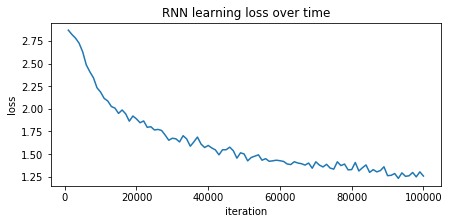

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(7, 3))
ax.plot([loss[0] for loss in all_losses], [loss[1] for loss in all_losses])
ax.set_title('RNN learning loss over time')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')

### Confusion matrix

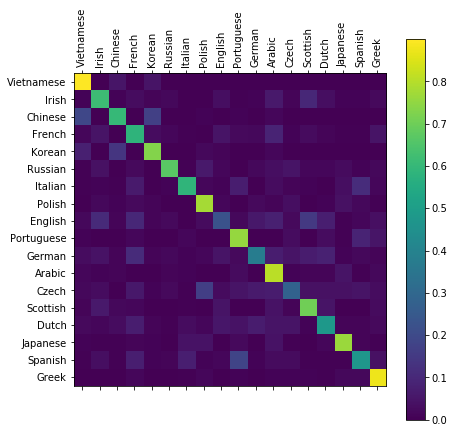

In [6]:
def evaluate(line_tensor, rnn):
    hidden = rnn.initHidden().to(get_device())
    line_tensor = line_tensor.to(get_device())

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = \
        random_training_example(all_categories, category_lines, all_letters)
    output = evaluate(line_tensor, rnn)
    guess, guess_i = category_from_output(output, all_categories)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig, ax = plt.subplots(figsize=(7, 7))
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

### Probabilistic evaluation

Get the probabilities.

In [7]:
import torch.nn.functional as F

results = []
truths = []

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = \
        random_training_example(all_categories, category_lines, all_letters)
    output = evaluate(line_tensor, rnn)
    probs = F.softmax(output, dim=1).cpu().detach().numpy()
    
    results.append(probs)
    truths.append(all_categories.index(category))
    
P, y = np.vstack(results), np.hstack(truths)

Micro-average the probabilistic predictions.

In [8]:
from sklearn.metrics import roc_curve, auc

num_classes = len(all_categories)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve([1 if label == i else 0 for label in y], P[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

y_test = np.array([[1 if label == i else 0 for label in y] for i in range(num_classes)]).ravel()
y_preds = P.T.ravel()
fpr['micro'], tpr['micro'], _ = roc_curve(y_test, y_preds)
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

Macro-average the probabilistic predictions.

In [9]:
from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr['macro'], tpr['macro'] = all_fpr, mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

Plot out the Receiver Operating Characteristic (ROC) curves.

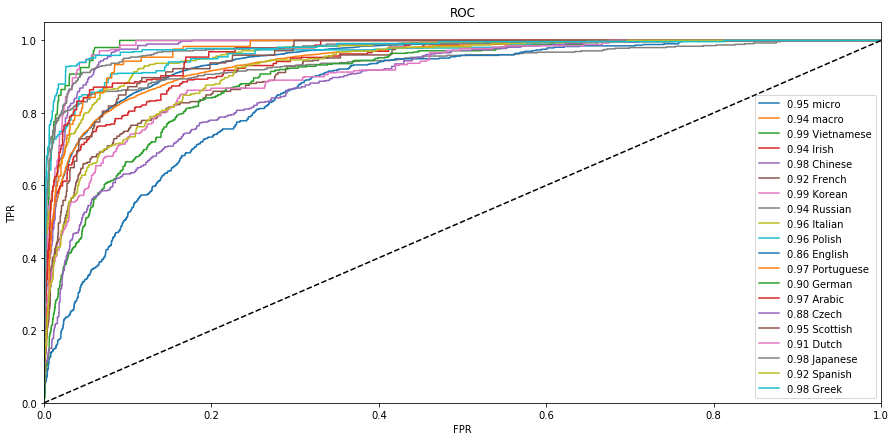

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(fpr['micro'], tpr['micro'], label=f'{roc_auc["micro"]:.2f} micro')
ax.plot(fpr['macro'], tpr['macro'], label=f'{roc_auc["macro"]:.2f} macro')

for k in fpr.keys():
    if k in ['micro', 'macro']:
        continue
    f = fpr[k]
    t = tpr[k]
    l = all_categories[k]
    r = roc_auc[k]
    
    ax.plot(f, t, label=f'{r:.2f} {l}')
    
ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('ROC')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_xlim([0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend()